# Fast Training of Convolutional Networks through FFTs

*Part1* Compare the FFT and direct Convolution

In [1]:
import os
import torch

import numpy as np
import torch.nn.functional as f
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from timeit import Timer
from torch import Tensor, nn
from torch.fft import irfftn, rfftn
from functools import partial,lru_cache, partial
from typing import Iterable, Tuple, Union,Callable, NamedTuple,Dict, Iterable, List, Optional, Sequence, Union


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def complex_matmul(a: Tensor, b: Tensor) -> Tensor:
    #doing complex multiplication
    scalar_matmul = partial(torch.einsum, "ab..., cb... -> ac...")
    real_part = scalar_matmul(a.real, b.real) - scalar_matmul(a.imag, b.imag)
    imag_part = scalar_matmul(a.imag, b.real) + scalar_matmul(a.real, b.imag)
    result = torch.zeros(real_part.shape, dtype=torch.complex64, device=a.device)
    result.real, result.imag = real_part, imag_part
    return result


In [4]:
def my_fft_conv(
    image: Tensor,
    kernel: Tensor,
    bias: Tensor = None,
    padding = 0,
) -> Tensor:

    # convert into tuple
    padding = (image.ndim - 2) * (0,)

    # Pad the tensors
    image_padding = [p for p in padding[::-1] for _ in range(2)]
    image = f.pad(image, image_padding)

    if image.size(-1) % 2 != 0:
        image_ = f.pad(image, [0, 1])
    else:
        image_ = image
    # Padding for kernel
    kernel_padding = [pad for i in reversed(range(2, image_.ndim)) for pad in [0, image_.size(i) - kernel.size(i)]]
    padded_kernel = f.pad(kernel, kernel_padding)

    # fourier convolution
    dim = tuple(range(2, image.ndim))
    image_ = image_.to(device)
    padded_kernel = padded_kernel.to(device)
    bias = bias.to(device)
    #FFT
    image_fft = rfftn(image_, dim=dim)
    kernel_fft = rfftn(padded_kernel, dim=dim)
    #complex mutiplication
    kernel_fft.imag *= -1
    output_fft = complex_matmul(image_fft, kernel_fft)
    #inverse FFT
    output = irfftn(output_fft, dim=dim)

    # Remove extra padded values
    crop_slices = [slice(0, output.size(0)), slice(0, output.size(1))] + [
        slice(0, (image.size(i) - kernel.size(i) + 1))
        for i in range(2, image.ndim)
    ]
    output = output[crop_slices].contiguous()

    # add a bias term before returning.
    if bias is not None:
        bias_shape = tuple([1, -1] + (image.ndim - 2) * [1])
        output += bias.view(bias_shape)

    return output


In [5]:
class FFTConv2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Iterable[int]],
        padding = 0,
        bias: bool = True,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.use_bias = bias

        #convert to a tuple
        kernel_size = 2 * (kernel_size,)
        weight = torch.randn(out_channels, in_channels, *kernel_size)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None

    def forward(self, image):
        return my_fft_conv(
            image,
            self.weight,
            bias=self.bias,
            padding=self.padding,
        )

In [6]:
import numpy as np

def conv2d(image, kernel, bias, stride=1, padding=0):
  # Get the dimensions of the input image, kernel, and bias
  batch_size, input_channel, input_height, input_width = image.shape
  output_channel, input_channel, kernel_height, kernel_width = kernel.shape
  output_channel, = bias.shape

  # Calculate the size of the output image
  output_height = (input_height - kernel_height + 2 * padding) // stride + 1
  output_width = (input_width - kernel_width + 2 * padding) // stride + 1

  # The array to store the convolved image
  result = torch.zeros(batch_size, output_channel, output_height, output_width)

  # Iterate over the batch
  for b in range(batch_size):
    # Iterate the output image
    for o in range(output_channel):
      # Iterateeach position in the output image
      for h in range(output_height):
        for w in range(output_width):
          # Calculate the start and end positions of the kernel
          # on the input image
          h_start = h * stride
          h_end = h_start + kernel_height
          w_start = w * stride
          w_end = w_start + kernel_width

          image = image.to(device)
          kernel = kernel.to(device)
          result = result.to(device)

          input_subarray = image[b, :, h_start:h_end, w_start:w_end]

          # Compute the dot product
          # add bias
          result[b, o, h, w] = torch.sum(input_subarray * kernel[o]) + bias[o]

  return result


**Expriment**

**Input size vs Time**

In [7]:
""""This section is varying the input size. For the simplexity, we choose batch size  = 1 kernel size = 7
    input channel = 1 output channel = 3. The range of the kernel is from 7 to 50.(Consist with paper) """
Naive_time_list = []
FFT_time_list = []

MIN_INPUT_SIZE = 7
MAX_INPUT_SIZE = 50
epoch = 20
input_size_list = list(range(MIN_INPUT_SIZE, MAX_INPUT_SIZE,5 ))

for input_size in tqdm(input_size_list):
    Naive_time = np.zeros(epoch)
    FFT_time = np.zeros(epoch)
    for run in range(epoch):
        #define a conv in pytorch
        #initialze the weight and bias in FFT and Naive 
        conv = nn.Conv2d(1, 3, 7)
        FFT_conv = FFTConv2d(1,3,7)

        #define input image
        input_image = torch.randint(low=0, high=10, size=(1, 1, input_size, input_size),  dtype=torch.float32)

        #initialize the weight and bias for FFT
        conv.weight = nn.Parameter(torch.randint(low=0, high=10, size=(3, 1, 7, 7),  dtype=torch.float32))
        FFT_conv.weight = conv.weight
        FFT_conv.bias = conv.bias

        #timing the output of FFT
        start = time()
        FFT_out = FFT_conv(input_image)
        FFT_time[run] = time() - start

        #initialize the weight and bias for Naive one
        kernel = conv.weight.detach()
        bias = conv.bias.detach()
        
        #timing the output of Naive
        start = time()
        Naive_conv = conv2d(input_image, kernel, bias)
        Naive_time[run] = time() - start
        
    Naive_time_list.append(Naive_time.mean())
    FFT_time_list.append(FFT_time.mean())



100%|██████████| 9/9 [00:31<00:00,  3.54s/it]


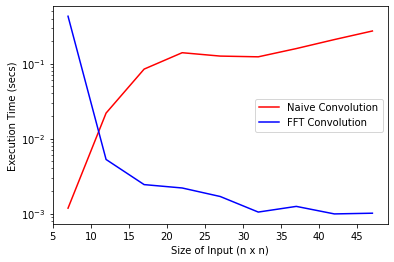

In [8]:
plt.plot(input_size_list, Naive_time_list,
         label='Naive Convolution', color='red')
plt.plot(input_size_list, FFT_time_list,
         label='FFT Convolution', color='blue')

plt.xlabel('Size of Input (n x n)')
plt.ylabel('Execution Time (secs)')
plt.yscale("log")
plt.legend()
plt.show()

**Kernel Size vs Time**

In [9]:
""""This section is varying the kernel size. For the simplexity, we choose batch size = 1, input channel = 1 output channel = 3
    input size of the image is 32 x 32. The range of the kernel is from 2 to 14.(Consist with paper) """
Naive_time_list = []
FFT_time_list = []

MIN_KERNEL_SIZE = 2
MAX_KERNEL_SIZE = 14
epoch = 20
kernel_sizes = list(range(MIN_KERNEL_SIZE, MAX_KERNEL_SIZE, 2))

for kernel_size in tqdm(kernel_sizes):
    Naive_time = np.zeros(epoch)
    FFT_time = np.zeros(epoch)
    for run in range(epoch):
        #define a conv in pytorch
        #initialze the weight and bias in FFT and Naive 
        conv = nn.Conv2d(1, 3, kernel_size)
        FFT_conv = FFTConv2d(1,3,kernel_size)
        #define input image
        input_image = torch.randint(low=0, high=10, size=(1, 1, 32, 32),  dtype=torch.float32)
        #initialize the weight and bias for FFT
        conv.weight = nn.Parameter(torch.randint(low=0, high=10, size=(3, 1, kernel_size, kernel_size),  dtype=torch.float32))
        FFT_conv.weight = conv.weight
        FFT_conv.bias = conv.bias

        #timing the output of FFT
        start = time()
        FFT_out = FFT_conv(input_image )
        FFT_time[run] = time() - start

        #initialize the weight and bias for Naive one
        kernel = conv.weight.detach()
        bias = conv.bias.detach()

        #timing the output of Naive
        start = time()
        Naive_conv = conv2d(input_image, kernel, bias)
        Naive_time[run] = time() - start
        
    Naive_time_list.append(Naive_time.mean())
    FFT_time_list.append(FFT_time.mean())


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


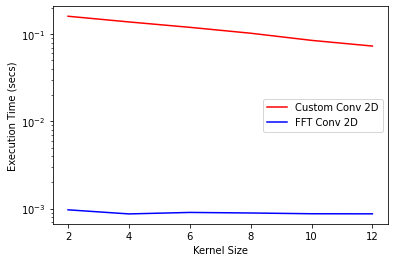

In [10]:
plt.plot(kernel_sizes, Naive_time_list,
         label='Custom Conv 2D', color='red')
plt.plot(kernel_sizes, FFT_time_list,
         label='FFT Conv 2D', color='blue')

plt.xlabel('Kernel Size')
plt.ylabel('Execution Time (secs)')
plt.yscale("log")
plt.legend()
plt.show()

**Batch Size vs time**

In [11]:
""""This section is varying the batch size. For the simplexity, we choose input size = 32 kernel size = 7
    input channel = 1 output channel = 3. The range of the batch size is from 1 to 10.(Consist with paper) """
Naive_time_list = []
FFT_time_list = []

MIN_BATCH_SIZE = 1
MAX_BATCH_SIZE = 10
epoch = 20
batch_size_list = list(range(MIN_BATCH_SIZE, MAX_BATCH_SIZE,1))

for batch_size in tqdm(batch_size_list):
    
    Naive_time = np.zeros(epoch)
    FFT_time = np.zeros(epoch)
    for run in range(epoch):
        #define a conv in pytorch
        #initialze the weight and bias in FFT and Naive 
        
        conv = nn.Conv2d(1, 3, 7)
        FFT_conv = FFTConv2d(1,3,7)
        #define input image
        
        input_image = torch.randint(low=0, high=10, size=(batch_size, 1, 32, 32),  dtype=torch.float32)
        #initialize the weight and bias for FFT
        
        conv.weight = nn.Parameter(torch.randint(low=0, high=10, size=(3, 1, 7, 7),  dtype=torch.float32))
        FFT_conv.weight = conv.weight
        FFT_conv.bias = conv.bias
        
        #timing the output of FFT
        start = time()
        FFT_out = FFT_conv(input_image)
        FFT_time[run] = time() - start
        #initialize the weight and bias for Naive one
        
        kernel = conv.weight.detach()
        bias = conv.bias.detach()
        #timing the output of Naive
        start = time()
        Naive_conv = conv2d(input_image, kernel, bias)
        Naive_time[run] = time() - start
        
    Naive_time_list.append(Naive_time.mean())
    FFT_time_list.append(FFT_time.mean())


100%|██████████| 9/9 [01:40<00:00, 11.21s/it]


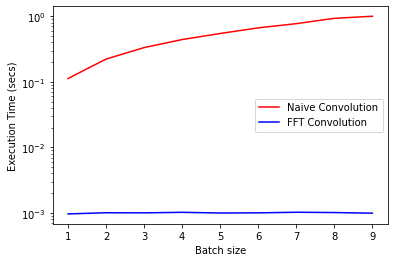

In [12]:
plt.plot(batch_size_list, Naive_time_list,
         label='Naive Convolution', color='r')
plt.plot(batch_size_list, FFT_time_list,
         label='FFT Convolution', color='b')

plt.xlabel('Batch size')
plt.ylabel('Execution Time (secs)')
plt.yscale("log")
plt.legend()
plt.show()